# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


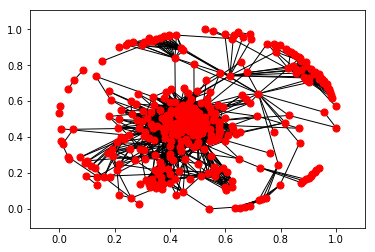

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

## 2. Data Preprocessing

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Tensorflow Settings (hyperparams) - ONLY RUN THIS CELL ONCE

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0.2, 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

In [10]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [11]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [12]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

## 3. Initialize VAE Model

In [13]:
# Define hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 200
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.2

In [14]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [15]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [16]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

In [17]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [18]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.90929 train_acc= 0.47304 val_roc= 0.79008 val_ap= 0.81441 time= 0.05525
Epoch: 0002 train_loss= 1.99865 train_acc= 0.48287 val_roc= 0.79072 val_ap= 0.81454 time= 0.01847
Epoch: 0003 train_loss= 1.80214 train_acc= 0.49008 val_roc= 0.79181 val_ap= 0.81478 time= 0.01826
Epoch: 0004 train_loss= 1.78472 train_acc= 0.48181 val_roc= 0.79258 val_ap= 0.81479 time= 0.02186
Epoch: 0005 train_loss= 1.59006 train_acc= 0.47952 val_roc= 0.79373 val_ap= 0.81508 time= 0.01845
Epoch: 0006 train_loss= 1.70977 train_acc= 0.48900 val_roc= 0.79392 val_ap= 0.81441 time= 0.01879
Epoch: 0007 train_loss= 1.62156 train_acc= 0.49209 val_roc= 0.79424 val_ap= 0.81375 time= 0.01855
Epoch: 0008 train_loss= 1.54292 train_acc= 0.48725 val_roc= 0.79507 val_ap= 0.81315 time= 0.01978
Epoch: 0009 train_loss= 1.55716 train_acc= 0.48936 val_roc= 0.79552 val_ap= 0.81283 time= 0.01905
Epoch: 0010 train_loss= 1.57159 train_acc= 0.49048 val_roc= 0.79622 val_ap= 0.81277 time= 0.01817
Epoch: 0011 train_lo

Epoch: 0088 train_loss= 0.66628 train_acc= 0.48332 val_roc= 0.85754 val_ap= 0.85520 time= 0.01975
Epoch: 0089 train_loss= 0.65517 train_acc= 0.49452 val_roc= 0.85811 val_ap= 0.85663 time= 0.02059
Epoch: 0090 train_loss= 0.64001 train_acc= 0.49991 val_roc= 0.85837 val_ap= 0.85724 time= 0.02762
Epoch: 0091 train_loss= 0.64007 train_acc= 0.50074 val_roc= 0.85734 val_ap= 0.85699 time= 0.02171
Epoch: 0092 train_loss= 0.64047 train_acc= 0.49577 val_roc= 0.85651 val_ap= 0.85675 time= 0.01946
Epoch: 0093 train_loss= 0.64100 train_acc= 0.50872 val_roc= 0.85658 val_ap= 0.85677 time= 0.01865
Epoch: 0094 train_loss= 0.62745 train_acc= 0.49916 val_roc= 0.85600 val_ap= 0.85677 time= 0.01922
Epoch: 0095 train_loss= 0.62848 train_acc= 0.50130 val_roc= 0.85562 val_ap= 0.85658 time= 0.01951
Epoch: 0096 train_loss= 0.62564 train_acc= 0.50707 val_roc= 0.85594 val_ap= 0.85707 time= 0.01888
Epoch: 0097 train_loss= 0.61670 train_acc= 0.51447 val_roc= 0.85542 val_ap= 0.85669 time= 0.01850
Epoch: 0098 train_lo

Epoch: 0177 train_loss= 0.57437 train_acc= 0.52726 val_roc= 0.87155 val_ap= 0.86348 time= 0.01902
Epoch: 0178 train_loss= 0.56985 train_acc= 0.52116 val_roc= 0.87226 val_ap= 0.86392 time= 0.02284
Epoch: 0179 train_loss= 0.56956 train_acc= 0.52424 val_roc= 0.87315 val_ap= 0.86451 time= 0.01974
Epoch: 0180 train_loss= 0.57182 train_acc= 0.52738 val_roc= 0.87328 val_ap= 0.86456 time= 0.01887
Epoch: 0181 train_loss= 0.57035 train_acc= 0.52823 val_roc= 0.87398 val_ap= 0.86553 time= 0.01860
Epoch: 0182 train_loss= 0.58134 train_acc= 0.51178 val_roc= 0.87418 val_ap= 0.86476 time= 0.01833
Epoch: 0183 train_loss= 0.57162 train_acc= 0.52241 val_roc= 0.87488 val_ap= 0.86532 time= 0.01835
Epoch: 0184 train_loss= 0.56992 train_acc= 0.52865 val_roc= 0.87526 val_ap= 0.86552 time= 0.01824
Epoch: 0185 train_loss= 0.56485 train_acc= 0.52814 val_roc= 0.87520 val_ap= 0.86547 time= 0.01845
Epoch: 0186 train_loss= 0.57057 train_acc= 0.51717 val_roc= 0.87546 val_ap= 0.86582 time= 0.01799
Epoch: 0187 train_lo